C:\Users\mason\AppData\Local\Temp\ipykernel_40020\3114424148.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("ABBV", period="10y")[["Open", "High", "Low", "Close", "Volume"]]
[*********************100%***********************]  1 of 1 completed


Mean Squared Error: 7.1669168353429695
R-squared: 0.9849038800183544

Predicted closing price for July 01, 2025: $190.47


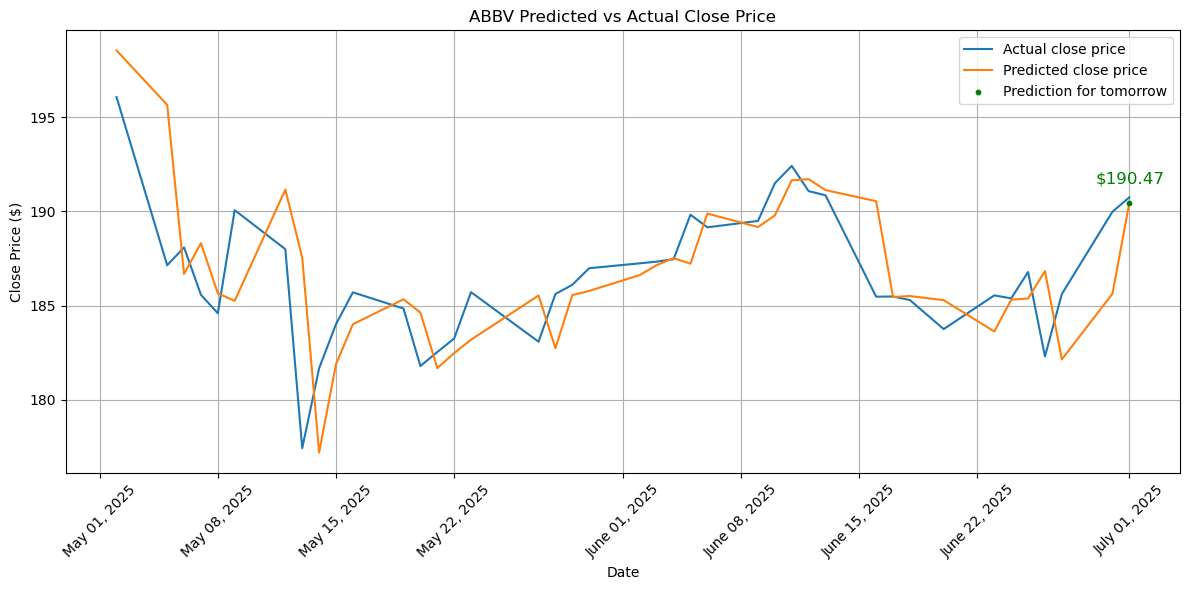

In [106]:
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

df = yf.download("ABBV", period="10y")[["Open", "High", "Low", "Close", "Volume"]]
df.reset_index(inplace=True)

# create date features
df["Day"] = df["Date"].dt.day
df["Month"] = df["Date"].dt.month
df["TimeIndex"] = range(len(df))

# get average price for past 5 days
df["SMA_5"] = df["Close"].rolling(window=5).mean()

# get exponential moving average for past 5 days
df["EMA_5"] = df["Close"].ewm(span=5, adjust=False).mean()

# target to predict next day
df["Target"] = df["Close"].shift(-1)

# drop nulls
df.dropna(inplace=True)

# features/labels
X = df[["Open", "High", "Low", "Close", "Volume", "SMA_5", "EMA_5",
        "Day", "Month", "TimeIndex"]]
y = df["Target"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)

# get mse and r^2
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, predictions)
print("R-squared:", r2)

# plot graph of last 2 months + prediction
test_dates = df["Date"].iloc[-len(y_test):]
last_2_months = test_dates >= (test_dates.max() - timedelta(days=60))

plot_dates = test_dates[last_2_months]
plot_actuals = y_test.values[last_2_months]
plot_predictions = predictions[last_2_months]

plt.figure(figsize=(12, 6))
plt.plot(plot_dates, plot_actuals, label='Actual close price')
plt.plot(plot_dates, plot_predictions, label='Predicted close price')

# highlight latest prediction
last_date = test_dates.iloc[-1]
last_pred = predictions[-1]
plt.scatter(last_date, last_pred, color = 'green', s = 10, zorder = 5, label = 'Prediction for tomorrow')
plt.text(last_date - timedelta(days=2), last_pred + 1, f"${last_pred:.2f}", color = 'green', fontsize = 12)

print(f"\nPredicted closing price for {last_date.strftime('%B %d, %Y')}: ${last_pred:.2f}")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B %d, %Y'))
plt.title("ABBV Predicted vs Actual Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


In [110]:
from sklearn.metrics import mean_squared_error, r2_score

# compare errors for training and test data
train_preds = model.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)

test_preds = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

print(f"Train MSE: {train_mse:.2f}, Test R²: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.2f}, Test R²: {test_r2:.4f}")


Train MSE: 1.75, Test R²: 0.9984
Test MSE: 7.17, Test R²: 0.9849
